# **Problem 4: convolutional neural networks (CNN)**

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torch.optim as optim
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from torchvision.transforms.functional import to_pil_image
from torchcam.methods import GradCAM

*Load CIFAR-10 dataset*

In [ ]:
# Transformations for CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)

# Split train dataset into training and validation sets
train_size = int(0.875 * len(train_dataset)) 
val_size = len(train_dataset) - train_size 

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Load datasets into DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Data loaded and split successfully.")

Files already downloaded and verified
Files already downloaded and verified
Data loaded and split successfully.


In [3]:
# Display dataset sizes
print(f"Training set size: {len(train_dataset)} samples")
print(f"Validation set size: {len(val_dataset)} samples")
print(f"Test set size: {len(test_dataset)} samples")

Training set size: 43750 samples
Validation set size: 6250 samples
Test set size: 10000 samples


In [4]:
print("Classes in CIFAR-10 dataset:", train_dataset.dataset.classes)

Classes in CIFAR-10 dataset: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# Part 1:

In [12]:
# 3-layer CNN for CIFAR-10 classification
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Applies 2x2 max pooling to reduce spatial dimensions by half
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 4 * 4, 256)   
        self.fc2 = nn.Linear(256, 10)  

    # Forward pass with ReLU
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss and accuracy values for each epoch
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []  

for epoch in range(10):
    # Training phase
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        optimizer.zero_grad()   # Reset gradients
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()   # Update weights
        total_train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Validation phase
    model.eval()
    total_val_loss = 0.0
    all_pred_labels, all_true_labels = [], []

    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            total_val_loss += criterion(outputs, labels).item()

            # Get predicted and true labels for evaluation
            _, predicted = torch.max(outputs.data, 1)
            all_pred_labels.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    # Compute average training, validation loss, and training accuracy
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_accuracy = 100 * correct_train / total_train
    val_accuracy = 100 * accuracy_score(all_true_labels, all_pred_labels)  

    # Append to lists
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/10], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

# Test phase
model.eval()
all_test_preds, all_test_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:  
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# Compute evaluation metrics on test data
accuracy = 100 * accuracy_score(all_test_labels, all_test_preds)
precision = precision_score(all_test_labels, all_test_preds, average='weighted')
recall = recall_score(all_test_labels, all_test_preds, average='weighted')
f1 = f1_score(all_test_labels, all_test_preds, average='weighted')

print(f'\nFinal Test Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Epoch [1/10], Train Loss: 1.4393, Validation Loss: 1.1024, Train Accuracy: 47.67%
Epoch [2/10], Train Loss: 1.0006, Validation Loss: 0.9467, Train Accuracy: 64.76%
Epoch [3/10], Train Loss: 0.7992, Validation Loss: 0.8720, Train Accuracy: 72.10%
Epoch [4/10], Train Loss: 0.6686, Validation Loss: 0.7737, Train Accuracy: 76.68%
Epoch [5/10], Train Loss: 0.5570, Validation Loss: 0.7636, Train Accuracy: 80.48%
Epoch [6/10], Train Loss: 0.4622, Validation Loss: 0.7973, Train Accuracy: 83.72%
Epoch [7/10], Train Loss: 0.3690, Validation Loss: 0.8216, Train Accuracy: 86.97%
Epoch [8/10], Train Loss: 0.2907, Validation Loss: 0.9661, Train Accuracy: 89.89%
Epoch [9/10], Train Loss: 0.2301, Validation Loss: 0.9308, Train Accuracy: 91.95%
Epoch [10/10], Train Loss: 0.1784, Validation Loss: 1.0873, Train Accuracy: 93.69%

Final Test Accuracy: 73.79%
Precision: 0.7429
Recall: 0.7379
F1-Score: 0.7389


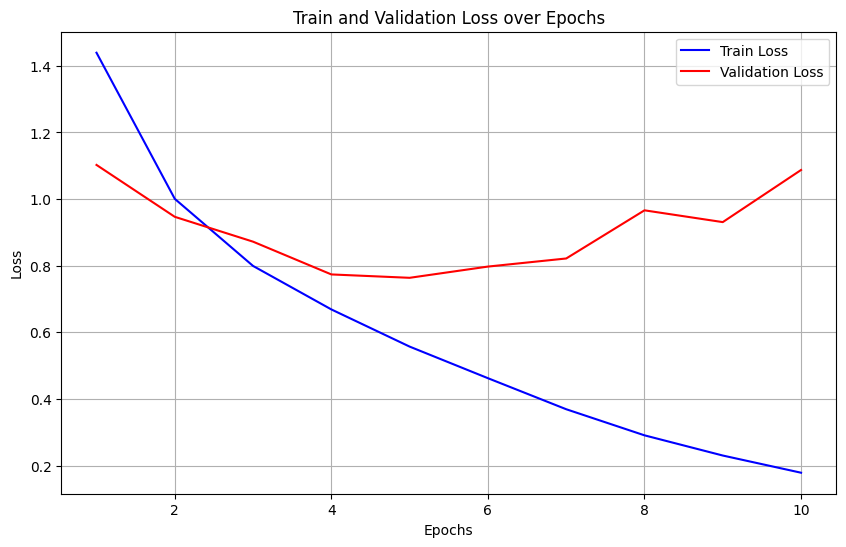

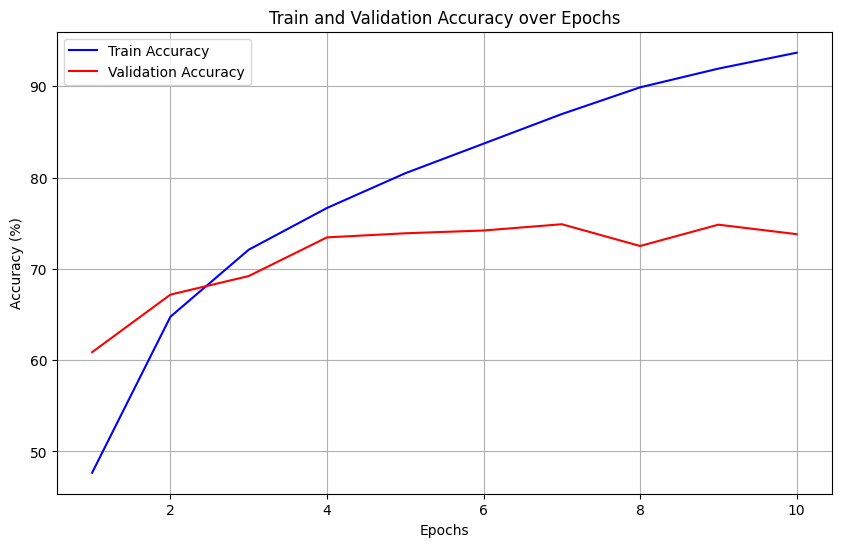

In [19]:
# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='red')
plt.title('Train and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='red')
plt.title('Train and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

# Part 2:

2-Layer CNN

In [20]:
# 2-layer CNN for CIFAR-10 classification
class CNN_2Layer(nn.Module):
    def __init__(self):
        super(CNN_2Layer, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # Applies 2x2 max pooling to reduce spatial dimensions by half
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    # Forward pass with ReLU
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [21]:
model = CNN_2Layer()  
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store average conv1 gradients, loss and accuracy values for each epoch
train_losses_2L, val_losses_2L = [], []
train_accuracies_2L, val_accuracies_2L = [], []
conv1_grads_2L = []

for epoch in range(10):
    # Training phase
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    epoch_first_layer_grads = []  

    for images, labels in train_loader:
        optimizer.zero_grad()   # Reset gradients
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        # Compute average conv1 gradients
        first_layer_grad = model.conv1.weight.grad.abs().mean().item()
        epoch_first_layer_grads.append(first_layer_grad)

        optimizer.step()   # Update weights

        total_train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Validation phase
    model.eval()
    total_val_loss = 0.0
    all_pred_labels, all_true_labels = [], []

    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            total_val_loss += criterion(outputs, labels).item()

            # Get predicted and true labels for evaluation
            _, predicted = torch.max(outputs.data, 1)
            all_pred_labels.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    # Compute average training, validation loss, and training accuracy
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_accuracy = 100 * correct_train / total_train
    val_accuracy = 100 * accuracy_score(all_true_labels, all_pred_labels)  

    # Append to lists
    train_losses_2L.append(avg_train_loss)
    val_losses_2L.append(avg_val_loss)
    train_accuracies_2L.append(train_accuracy)
    val_accuracies_2L.append(val_accuracy)

    # Compute average gradient of the first conv layer in this epoch
    avg_first_layer_grad = sum(epoch_first_layer_grads) / len(epoch_first_layer_grads)
    conv1_grads_2L.append(avg_first_layer_grad)

    print(f'Epoch [{epoch + 1}/10], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, Avg First Layer Gradient: {avg_first_layer_grad:.6f}')

# Test phase
model.eval()
all_test_preds, all_test_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:  
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# Compute evaluation metrics on test data
accuracy = 100 * accuracy_score(all_test_labels, all_test_preds)
precision = precision_score(all_test_labels, all_test_preds, average='weighted')
recall = recall_score(all_test_labels, all_test_preds, average='weighted')
f1 = f1_score(all_test_labels, all_test_preds, average='weighted')

print(f'\nFinal Test Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Epoch [1/10], Train Loss: 1.3566, Validation Loss: 1.0878, Train Accuracy: 51.15%, Avg First Layer Gradient: 0.031370
Epoch [2/10], Train Loss: 0.9548, Validation Loss: 0.9152, Train Accuracy: 66.30%, Avg First Layer Gradient: 0.043559
Epoch [3/10], Train Loss: 0.7806, Validation Loss: 0.8584, Train Accuracy: 72.74%, Avg First Layer Gradient: 0.047274
Epoch [4/10], Train Loss: 0.6444, Validation Loss: 0.8236, Train Accuracy: 77.57%, Avg First Layer Gradient: 0.047704
Epoch [5/10], Train Loss: 0.5108, Validation Loss: 0.8584, Train Accuracy: 82.31%, Avg First Layer Gradient: 0.046608
Epoch [6/10], Train Loss: 0.3898, Validation Loss: 0.9009, Train Accuracy: 86.54%, Avg First Layer Gradient: 0.044675
Epoch [7/10], Train Loss: 0.2797, Validation Loss: 1.0256, Train Accuracy: 90.51%, Avg First Layer Gradient: 0.042233
Epoch [8/10], Train Loss: 0.1924, Validation Loss: 1.1307, Train Accuracy: 93.49%, Avg First Layer Gradient: 0.038026
Epoch [9/10], Train Loss: 0.1293, Validation Loss: 1.328

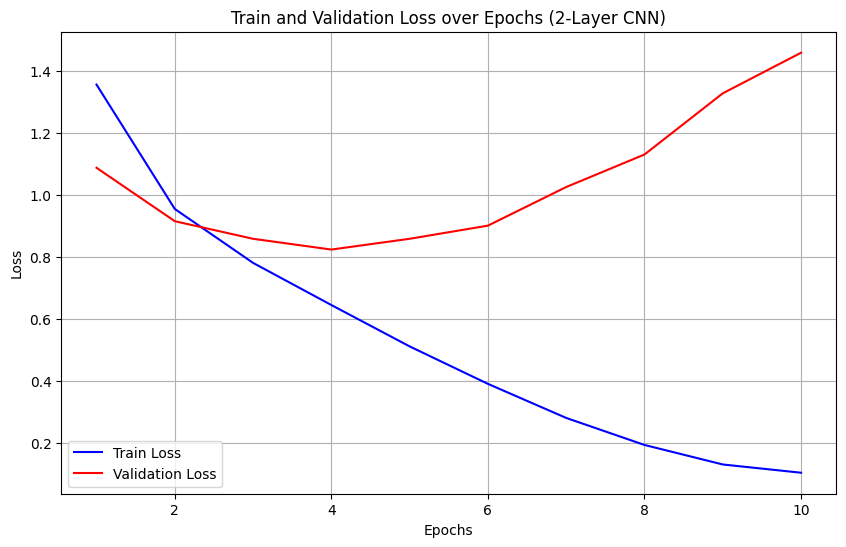

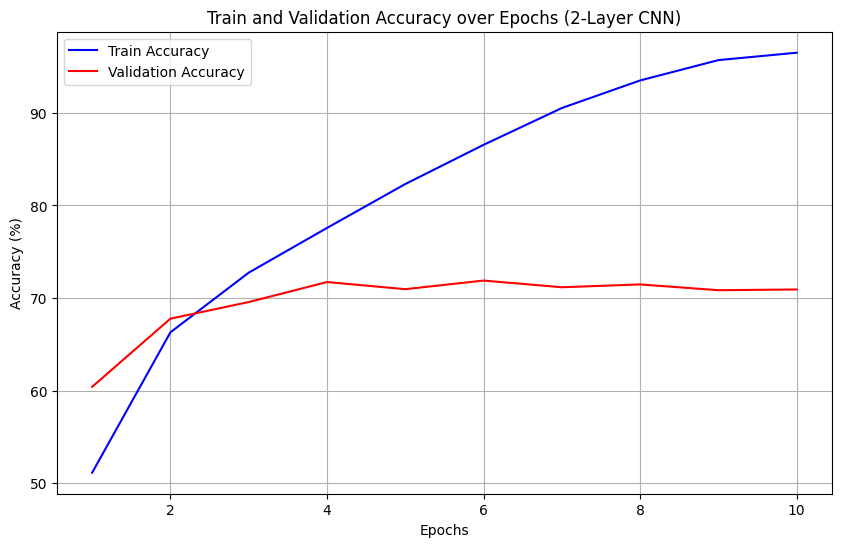

In [22]:
# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses_2L) + 1), train_losses_2L, label='Train Loss', color='blue')
plt.plot(range(1, len(val_losses_2L) + 1), val_losses_2L, label='Validation Loss', color='red')
plt.title('Train and Validation Loss over Epochs (2-Layer CNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies_2L) + 1), train_accuracies_2L, label='Train Accuracy', color='blue')
plt.plot(range(1, len(val_accuracies_2L) + 1), val_accuracies_2L, label='Validation Accuracy', color='red')
plt.title('Train and Validation Accuracy over Epochs (2-Layer CNN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

4-Layer CNN

In [23]:
# 4-layer CNN for CIFAR-10 classification
class CNN_4Layer(nn.Module):
    def __init__(self):
        super(CNN_4Layer, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        # Applies 2x2 max pooling to reduce spatial dimensions by half
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(256 * 2 * 2, 256)
        self.fc2 = nn.Linear(256, 10)

    # Forward pass with ReLU
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 256 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [24]:
model = CNN_4Layer()  
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store average conv1 gradients, loss and accuracy values for each epoch
train_losses_4L, val_losses_4L = [], []
train_accuracies_4L, val_accuracies_4L = [], []
conv1_grads_4L = []  

for epoch in range(10):
    # Training phase
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    epoch_first_layer_grads = []  

    for images, labels in train_loader:
        optimizer.zero_grad()   # Reset gradients
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        # Compute average conv1 gradients
        first_layer_grad = model.conv1.weight.grad.abs().mean().item()
        epoch_first_layer_grads.append(first_layer_grad)

        optimizer.step()   # Update weights

        total_train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Validation phase
    model.eval()
    total_val_loss = 0.0
    all_pred_labels, all_true_labels = [], []

    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            total_val_loss += criterion(outputs, labels).item()

            # Get predicted and true labels for evaluation
            _, predicted = torch.max(outputs.data, 1)
            all_pred_labels.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    # Compute average training, validation loss, and training accuracy
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_accuracy = 100 * correct_train / total_train
    val_accuracy = 100 * accuracy_score(all_true_labels, all_pred_labels)   

    # Append to lists
    train_losses_4L.append(avg_train_loss)
    val_losses_4L.append(avg_val_loss)
    train_accuracies_4L.append(train_accuracy)
    val_accuracies_4L.append(val_accuracy)

    # Compute average gradient of the first conv layer in this epoch
    avg_first_layer_grad = sum(epoch_first_layer_grads) / len(epoch_first_layer_grads)
    conv1_grads_4L.append(avg_first_layer_grad)

    print(f'Epoch [{epoch + 1}/10], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, Avg First Layer Gradient: {avg_first_layer_grad:.6f}')

# Test phase
model.eval()
all_test_preds, all_test_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:  
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# Compute evaluation metrics on test data
accuracy = 100 * accuracy_score(all_test_labels, all_test_preds)
precision = precision_score(all_test_labels, all_test_preds, average='weighted')
recall = recall_score(all_test_labels, all_test_preds, average='weighted')
f1 = f1_score(all_test_labels, all_test_preds, average='weighted')

print(f'\nFinal Test Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Epoch [1/10], Train Loss: 1.4880, Validation Loss: 1.1937, Train Accuracy: 44.64%, Avg First Layer Gradient: 0.037353
Epoch [2/10], Train Loss: 1.0306, Validation Loss: 0.9368, Train Accuracy: 63.18%, Avg First Layer Gradient: 0.052524
Epoch [3/10], Train Loss: 0.7972, Validation Loss: 0.8135, Train Accuracy: 72.04%, Avg First Layer Gradient: 0.055204
Epoch [4/10], Train Loss: 0.6401, Validation Loss: 0.7540, Train Accuracy: 77.58%, Avg First Layer Gradient: 0.057983
Epoch [5/10], Train Loss: 0.5160, Validation Loss: 0.7100, Train Accuracy: 81.66%, Avg First Layer Gradient: 0.060815
Epoch [6/10], Train Loss: 0.4042, Validation Loss: 0.7339, Train Accuracy: 85.81%, Avg First Layer Gradient: 0.060235
Epoch [7/10], Train Loss: 0.3135, Validation Loss: 0.8398, Train Accuracy: 88.97%, Avg First Layer Gradient: 0.061238
Epoch [8/10], Train Loss: 0.2384, Validation Loss: 0.8644, Train Accuracy: 91.54%, Avg First Layer Gradient: 0.060431
Epoch [9/10], Train Loss: 0.1765, Validation Loss: 1.053

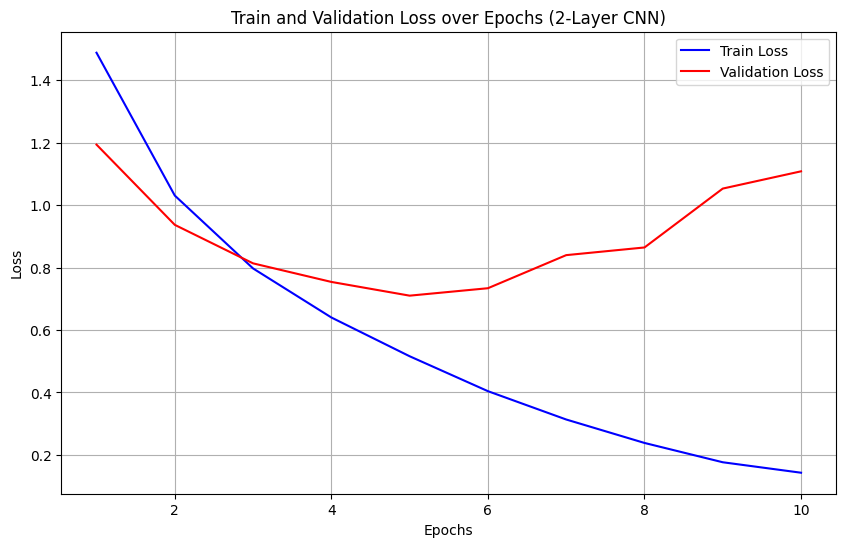

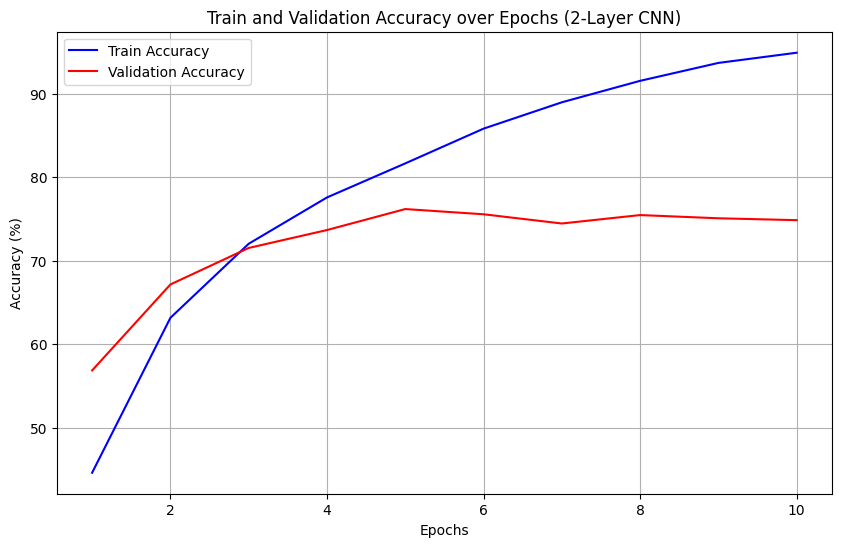

In [25]:
# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses_4L) + 1), train_losses_4L, label='Train Loss', color='blue')
plt.plot(range(1, len(val_losses_4L) + 1), val_losses_4L, label='Validation Loss', color='red')
plt.title('Train and Validation Loss over Epochs (2-Layer CNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies_4L) + 1), train_accuracies_4L, label='Train Accuracy', color='blue')
plt.plot(range(1, len(val_accuracies_4L) + 1), val_accuracies_4L, label='Validation Accuracy', color='red')
plt.title('Train and Validation Accuracy over Epochs (2-Layer CNN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

5-Layer CNN

In [26]:
# 5-layer CNN for CIFAR-10 classification
class CNN_5Layer(nn.Module):
    def __init__(self):
        super(CNN_5Layer, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)

        # Applies 2x2 max pooling to reduce spatial dimensions by half
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(512 * 1 * 1, 256)
        self.fc2 = nn.Linear(256, 10)

    # Forward pass with ReLU
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(-1, 512 * 1 * 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [27]:
model = CNN_5Layer()  
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store average conv1 gradients, loss and accuracy values for each epoch
train_losses_5L, val_losses_5L = [], []
train_accuracies_5L, val_accuracies_5L = [], []
conv1_grads_5L = []  

for epoch in range(10):
    # Training phase
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    epoch_first_layer_grads = []  

    for images, labels in train_loader:
        optimizer.zero_grad()   # Reset gradients
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        # Compute average conv1 gradients
        first_layer_grad = model.conv1.weight.grad.abs().mean().item()
        epoch_first_layer_grads.append(first_layer_grad)

        optimizer.step()   # Update weights

        total_train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Validation phase
    model.eval()
    total_val_loss = 0.0
    all_pred_labels, all_true_labels = [], []

    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            total_val_loss += criterion(outputs, labels).item()

            # Get predicted and true labels for evaluation
            _, predicted = torch.max(outputs.data, 1)
            all_pred_labels.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    # Compute average training, validation loss, and training accuracy
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_accuracy = 100 * correct_train / total_train
    val_accuracy = 100 * accuracy_score(all_true_labels, all_pred_labels)   

    # Append to lists
    train_losses_5L.append(avg_train_loss)
    val_losses_5L.append(avg_val_loss)
    train_accuracies_5L.append(train_accuracy)
    val_accuracies_5L.append(val_accuracy)

    # Compute average gradient of the first conv layer in this epoch
    avg_first_layer_grad = sum(epoch_first_layer_grads) / len(epoch_first_layer_grads)
    conv1_grads_5L.append(avg_first_layer_grad)

    print(f'Epoch [{epoch + 1}/10], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, Avg First Layer Gradient: {avg_first_layer_grad:.6f}')

# Test phase
model.eval()
all_test_preds, all_test_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:  
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# Compute evaluation metrics on test data
accuracy = 100 * accuracy_score(all_test_labels, all_test_preds)
precision = precision_score(all_test_labels, all_test_preds, average='weighted')
recall = recall_score(all_test_labels, all_test_preds, average='weighted')
f1 = f1_score(all_test_labels, all_test_preds, average='weighted')

print(f'\nFinal Test Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Epoch [1/10], Train Loss: 1.5135, Validation Loss: 1.1627, Train Accuracy: 43.07%, Avg First Layer Gradient: 0.040763
Epoch [2/10], Train Loss: 1.0519, Validation Loss: 0.9156, Train Accuracy: 62.22%, Avg First Layer Gradient: 0.054547
Epoch [3/10], Train Loss: 0.8049, Validation Loss: 0.8506, Train Accuracy: 71.69%, Avg First Layer Gradient: 0.061824
Epoch [4/10], Train Loss: 0.6532, Validation Loss: 0.7665, Train Accuracy: 77.01%, Avg First Layer Gradient: 0.065660
Epoch [5/10], Train Loss: 0.5249, Validation Loss: 0.7272, Train Accuracy: 81.58%, Avg First Layer Gradient: 0.065988
Epoch [6/10], Train Loss: 0.4211, Validation Loss: 0.7852, Train Accuracy: 85.27%, Avg First Layer Gradient: 0.068639
Epoch [7/10], Train Loss: 0.3269, Validation Loss: 0.8454, Train Accuracy: 88.45%, Avg First Layer Gradient: 0.068308
Epoch [8/10], Train Loss: 0.2523, Validation Loss: 0.9193, Train Accuracy: 91.25%, Avg First Layer Gradient: 0.069281
Epoch [9/10], Train Loss: 0.2014, Validation Loss: 1.023

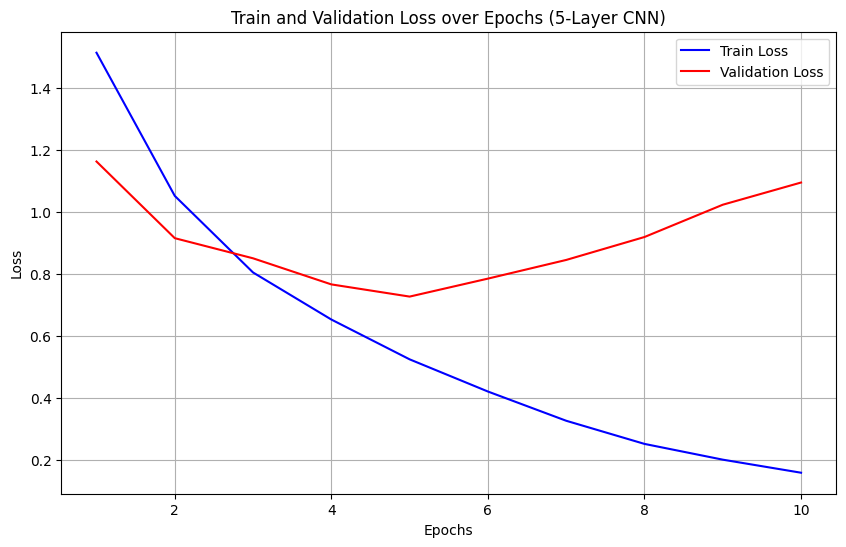

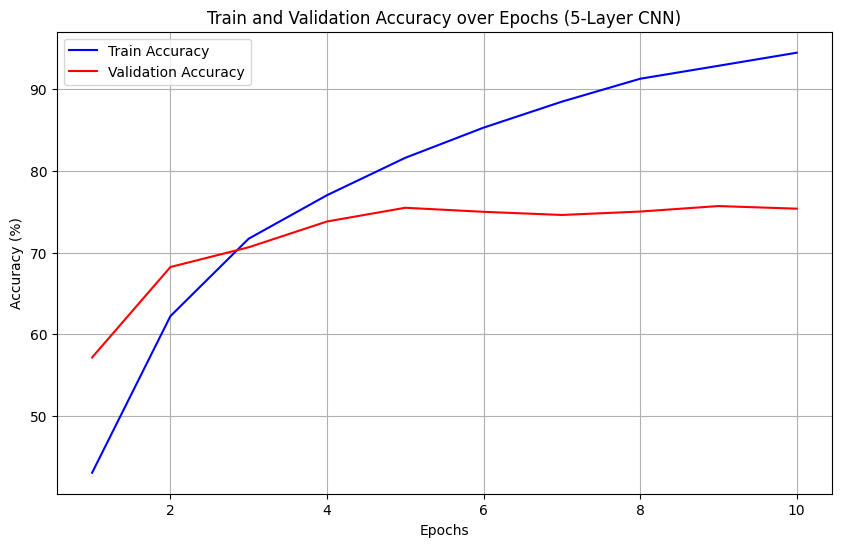

In [28]:
# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses_5L) + 1), train_losses_5L, label='Train Loss', color='blue')
plt.plot(range(1, len(val_losses_5L) + 1), val_losses_5L, label='Validation Loss', color='red')
plt.title('Train and Validation Loss over Epochs (5-Layer CNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies_5L) + 1), train_accuracies_5L, label='Train Accuracy', color='blue')
plt.plot(range(1, len(val_accuracies_5L) + 1), val_accuracies_5L, label='Validation Accuracy', color='red')
plt.title('Train and Validation Accuracy over Epochs (5-Layer CNN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

# Part 3:

Dropout = 0.5 , weight_decay = 0.0001

In [ ]:
# 3-layer CNN with dropout and Weight Decay for CIFAR-10 classification
class CNN_Dropout(nn.Module):
    def __init__(self):
        super(CNN_Dropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.dropout = nn.Dropout(0.5) 
        self.fc2 = nn.Linear(256, 10)

    # Forward pass with ReLU and dropout
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)   # Applying Dropout
        x = self.fc2(x)
        return x

In [37]:
model = CNN_Dropout()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

# Lists to store loss and accuracy values for each epoch
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []  

for epoch in range(10):
    # Training phase
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        optimizer.zero_grad()   # Reset gradients
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()   # Update weights
        total_train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Validation phase
    model.eval()
    total_val_loss = 0.0
    all_pred_labels, all_true_labels = [], []

    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            total_val_loss += criterion(outputs, labels).item()

            # Get predicted and true labels for evaluation
            _, predicted = torch.max(outputs.data, 1)
            all_pred_labels.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    # Compute average training, validation loss, and training accuracy
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_accuracy = 100 * correct_train / total_train
    val_accuracy = 100 * accuracy_score(all_true_labels, all_pred_labels)  

    # Append to lists
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/10], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

# Test phase
model.eval()
all_test_preds, all_test_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:  
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# Compute evaluation metrics on test data
accuracy = 100 * accuracy_score(all_test_labels, all_test_preds)
precision = precision_score(all_test_labels, all_test_preds, average='weighted')
recall = recall_score(all_test_labels, all_test_preds, average='weighted')
f1 = f1_score(all_test_labels, all_test_preds, average='weighted')

print(f'\nFinal Test Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Epoch [1/10], Train Loss: 1.5350, Validation Loss: 1.2204, Train Accuracy: 43.71%
Epoch [2/10], Train Loss: 1.1566, Validation Loss: 1.0112, Train Accuracy: 58.63%
Epoch [3/10], Train Loss: 0.9599, Validation Loss: 0.8425, Train Accuracy: 66.16%
Epoch [4/10], Train Loss: 0.8348, Validation Loss: 0.7812, Train Accuracy: 70.83%
Epoch [5/10], Train Loss: 0.7370, Validation Loss: 0.7440, Train Accuracy: 74.18%
Epoch [6/10], Train Loss: 0.6666, Validation Loss: 0.7194, Train Accuracy: 76.76%
Epoch [7/10], Train Loss: 0.6060, Validation Loss: 0.7014, Train Accuracy: 78.81%
Epoch [8/10], Train Loss: 0.5544, Validation Loss: 0.6977, Train Accuracy: 80.55%
Epoch [9/10], Train Loss: 0.4998, Validation Loss: 0.7202, Train Accuracy: 82.46%
Epoch [10/10], Train Loss: 0.4640, Validation Loss: 0.7400, Train Accuracy: 83.52%

Final Test Accuracy: 76.67%
Precision: 0.7739
Recall: 0.7667
F1-Score: 0.7684


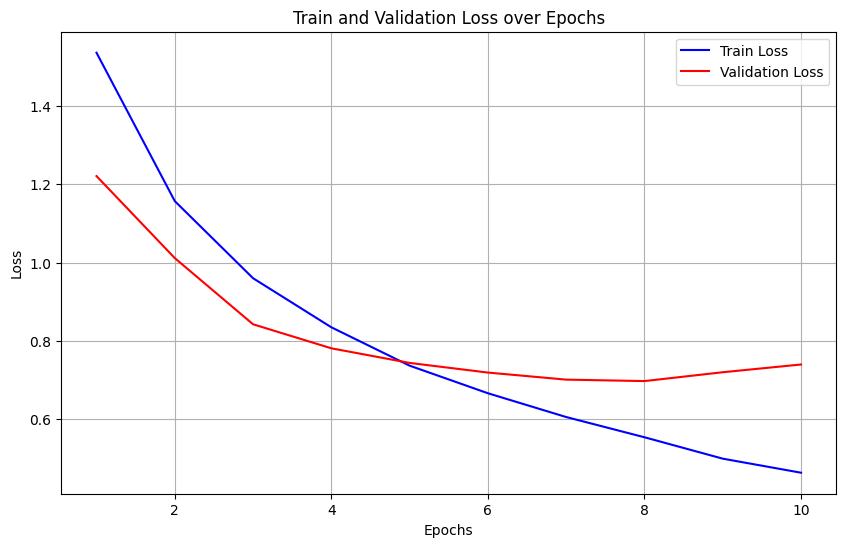

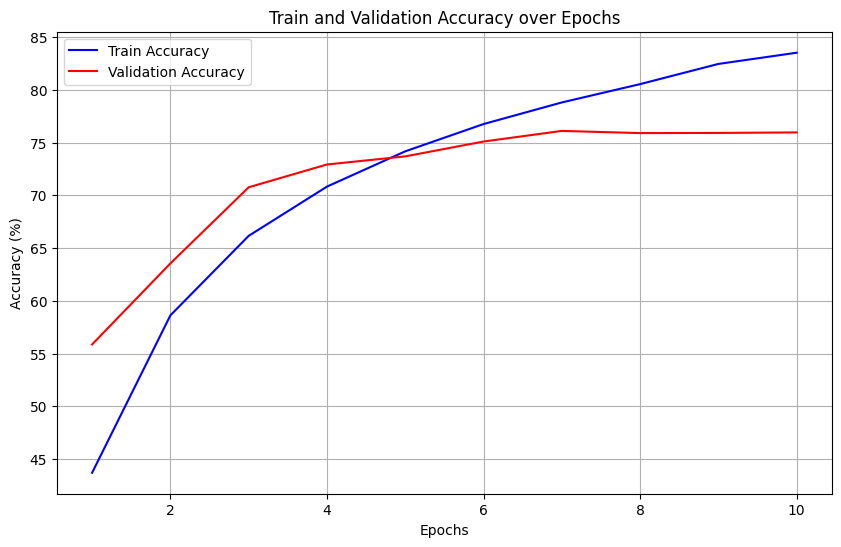

In [ ]:
# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='red')
plt.title('Train and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='red')
plt.title('Train and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

Dropout = 0.4 , weight_decay = 0.001

In [ ]:
# 3-layer CNN with dropout and Weight Decay for CIFAR-10 classification
class CNN_Dropout(nn.Module):
    def __init__(self):
        super(CNN_Dropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.dropout = nn.Dropout(0.4) 
        self.fc2 = nn.Linear(256, 10)

    # Forward pass with ReLU and dropout
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)   # Applying Dropout
        x = self.fc2(x)
        return x

In [40]:
model = CNN_Dropout()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# Lists to store loss and accuracy values for each epoch
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []  

for epoch in range(10):
    # Training phase
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        optimizer.zero_grad()   # Reset gradients
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()   # Update weights
        total_train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Validation phase
    model.eval()
    total_val_loss = 0.0
    all_pred_labels, all_true_labels = [], []

    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            total_val_loss += criterion(outputs, labels).item()

            # Get predicted and true labels for evaluation
            _, predicted = torch.max(outputs.data, 1)
            all_pred_labels.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    # Compute average training, validation loss, and training accuracy
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_accuracy = 100 * correct_train / total_train
    val_accuracy = 100 * accuracy_score(all_true_labels, all_pred_labels)  

    # Append to lists
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/10], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

# Test phase
model.eval()
all_test_preds, all_test_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:  
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# Compute evaluation metrics on test data
accuracy = 100 * accuracy_score(all_test_labels, all_test_preds)
precision = precision_score(all_test_labels, all_test_preds, average='weighted')
recall = recall_score(all_test_labels, all_test_preds, average='weighted')
f1 = f1_score(all_test_labels, all_test_preds, average='weighted')

print(f'\nFinal Test Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Epoch [1/10], Train Loss: 1.5418, Validation Loss: 1.2471, Train Accuracy: 43.40%
Epoch [2/10], Train Loss: 1.1551, Validation Loss: 0.9817, Train Accuracy: 58.94%
Epoch [3/10], Train Loss: 0.9818, Validation Loss: 0.8970, Train Accuracy: 65.39%
Epoch [4/10], Train Loss: 0.8722, Validation Loss: 0.8411, Train Accuracy: 69.42%
Epoch [5/10], Train Loss: 0.7970, Validation Loss: 0.7825, Train Accuracy: 72.33%
Epoch [6/10], Train Loss: 0.7467, Validation Loss: 0.7578, Train Accuracy: 74.21%
Epoch [7/10], Train Loss: 0.6975, Validation Loss: 0.7783, Train Accuracy: 75.68%
Epoch [8/10], Train Loss: 0.6576, Validation Loss: 0.7207, Train Accuracy: 77.17%
Epoch [9/10], Train Loss: 0.6235, Validation Loss: 0.6990, Train Accuracy: 78.33%
Epoch [10/10], Train Loss: 0.5968, Validation Loss: 0.7028, Train Accuracy: 79.36%

Final Test Accuracy: 76.61%
Precision: 0.7657
Recall: 0.7661
F1-Score: 0.7627


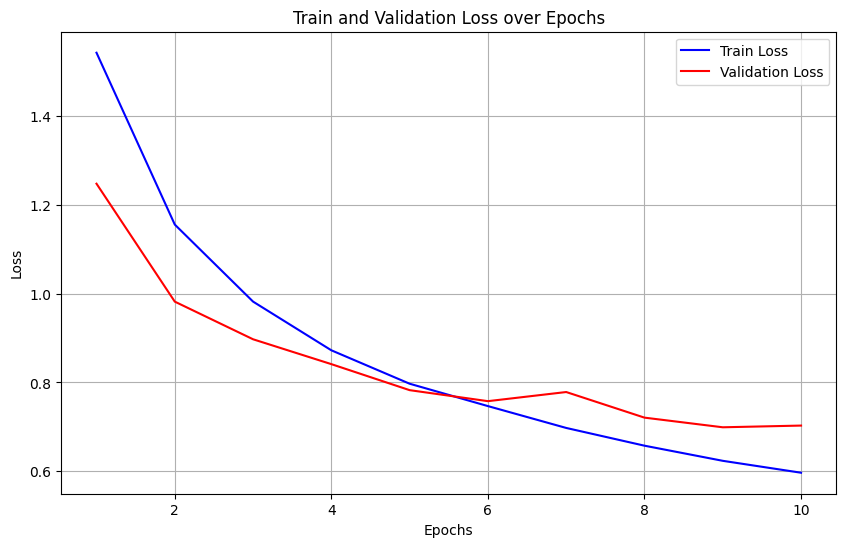

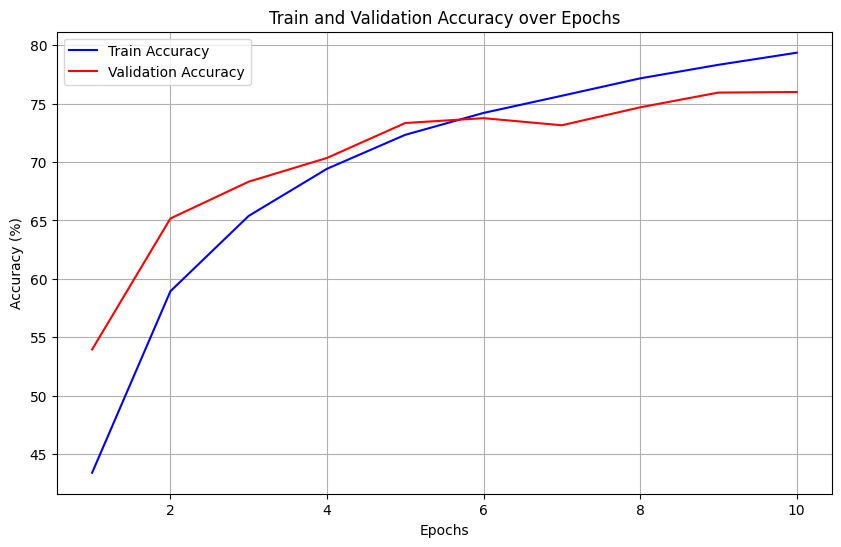

In [ ]:
# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='red')
plt.title('Train and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='red')
plt.title('Train and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

Dropout = 0.4 , weight_decay = 0.01

In [ ]:
# 3-layer CNN with dropout and Weight Decay for CIFAR-10 classification
class CNN_Dropout(nn.Module):
    def __init__(self):
        super(CNN_Dropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.dropout = nn.Dropout(0.4) 
        self.fc2 = nn.Linear(256, 10)

    # Forward pass with ReLU and dropout
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)   # Applying Dropout
        x = self.fc2(x)
        return x

In [7]:
model = CNN_Dropout()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

# Lists to store loss and accuracy values for each epoch
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []  

for epoch in range(10):
    # Training phase
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        optimizer.zero_grad()   # Reset gradients
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()   # Update weights
        total_train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Validation phase
    model.eval()
    total_val_loss = 0.0
    all_pred_labels, all_true_labels = [], []

    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            total_val_loss += criterion(outputs, labels).item()

            # Get predicted and true labels for evaluation
            _, predicted = torch.max(outputs.data, 1)
            all_pred_labels.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    # Compute average training, validation loss, and training accuracy
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_accuracy = 100 * correct_train / total_train
    val_accuracy = 100 * accuracy_score(all_true_labels, all_pred_labels)  

    # Append to lists
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/10], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

# Test phase
model.eval()
all_test_preds, all_test_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:  
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# Compute evaluation metrics on test data
accuracy = 100 * accuracy_score(all_test_labels, all_test_preds)
precision = precision_score(all_test_labels, all_test_preds, average='weighted')
recall = recall_score(all_test_labels, all_test_preds, average='weighted')
f1 = f1_score(all_test_labels, all_test_preds, average='weighted')

print(f'\nFinal Test Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Epoch [1/10], Train Loss: 1.6741, Validation Loss: 1.4190, Train Accuracy: 38.03%
Epoch [2/10], Train Loss: 1.4112, Validation Loss: 1.3082, Train Accuracy: 48.51%
Epoch [3/10], Train Loss: 1.3153, Validation Loss: 1.2271, Train Accuracy: 52.42%
Epoch [4/10], Train Loss: 1.2393, Validation Loss: 1.1555, Train Accuracy: 55.53%
Epoch [5/10], Train Loss: 1.1808, Validation Loss: 1.1033, Train Accuracy: 58.14%
Epoch [6/10], Train Loss: 1.1290, Validation Loss: 1.0475, Train Accuracy: 60.36%
Epoch [7/10], Train Loss: 1.0902, Validation Loss: 0.9952, Train Accuracy: 61.48%
Epoch [8/10], Train Loss: 1.0686, Validation Loss: 0.9897, Train Accuracy: 62.31%
Epoch [9/10], Train Loss: 1.0515, Validation Loss: 0.9752, Train Accuracy: 63.09%
Epoch [10/10], Train Loss: 1.0364, Validation Loss: 0.9463, Train Accuracy: 63.83%

Final Test Accuracy: 67.45%
Precision: 0.6776
Recall: 0.6745
F1-Score: 0.6743


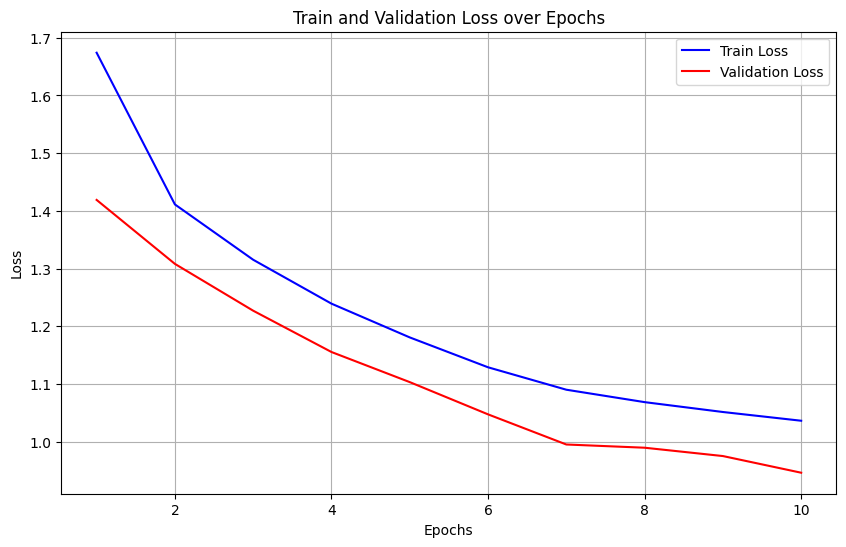

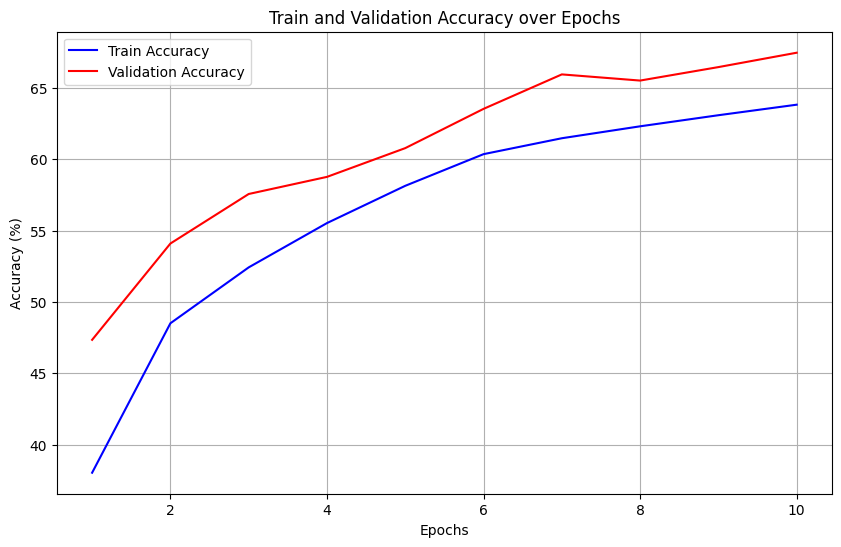

In [8]:
# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='red')
plt.title('Train and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='red')
plt.title('Train and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

Dropout = 0.3 , weight_decay = 0.001

In [9]:
# 3-layer CNN with dropout and Weight Decay for CIFAR-10 classification
class CNN_Dropout(nn.Module):
    def __init__(self):
        super(CNN_Dropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.dropout = nn.Dropout(0.3) 
        self.fc2 = nn.Linear(256, 10)

    # Forward pass with ReLU and dropout
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)   # Applying Dropout
        x = self.fc2(x)
        return x

In [10]:
model = CNN_Dropout()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

# Lists to store loss and accuracy values for each epoch
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []  

for epoch in range(10):
    # Training phase
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        optimizer.zero_grad()   # Reset gradients
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()   # Update weights
        total_train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Validation phase
    model.eval()
    total_val_loss = 0.0
    all_pred_labels, all_true_labels = [], []

    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            total_val_loss += criterion(outputs, labels).item()

            # Get predicted and true labels for evaluation
            _, predicted = torch.max(outputs.data, 1)
            all_pred_labels.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    # Compute average training, validation loss, and training accuracy
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_accuracy = 100 * correct_train / total_train
    val_accuracy = 100 * accuracy_score(all_true_labels, all_pred_labels)  

    # Append to lists
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/10], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

# Test phase
model.eval()
all_test_preds, all_test_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:  
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# Compute evaluation metrics on test data
accuracy = 100 * accuracy_score(all_test_labels, all_test_preds)
precision = precision_score(all_test_labels, all_test_preds, average='weighted')
recall = recall_score(all_test_labels, all_test_preds, average='weighted')
f1 = f1_score(all_test_labels, all_test_preds, average='weighted')

print(f'\nFinal Test Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Epoch [1/10], Train Loss: 1.6720, Validation Loss: 1.4480, Train Accuracy: 37.91%
Epoch [2/10], Train Loss: 1.4011, Validation Loss: 1.3066, Train Accuracy: 48.54%
Epoch [3/10], Train Loss: 1.2884, Validation Loss: 1.2324, Train Accuracy: 53.42%
Epoch [4/10], Train Loss: 1.2129, Validation Loss: 1.1461, Train Accuracy: 56.45%
Epoch [5/10], Train Loss: 1.1572, Validation Loss: 1.0661, Train Accuracy: 58.82%
Epoch [6/10], Train Loss: 1.1125, Validation Loss: 1.0700, Train Accuracy: 60.47%
Epoch [7/10], Train Loss: 1.0735, Validation Loss: 1.0047, Train Accuracy: 62.30%
Epoch [8/10], Train Loss: 1.0460, Validation Loss: 0.9765, Train Accuracy: 63.32%
Epoch [9/10], Train Loss: 1.0303, Validation Loss: 0.9774, Train Accuracy: 63.88%
Epoch [10/10], Train Loss: 1.0177, Validation Loss: 0.9646, Train Accuracy: 64.45%

Final Test Accuracy: 67.71%
Precision: 0.6724
Recall: 0.6771
F1-Score: 0.6697


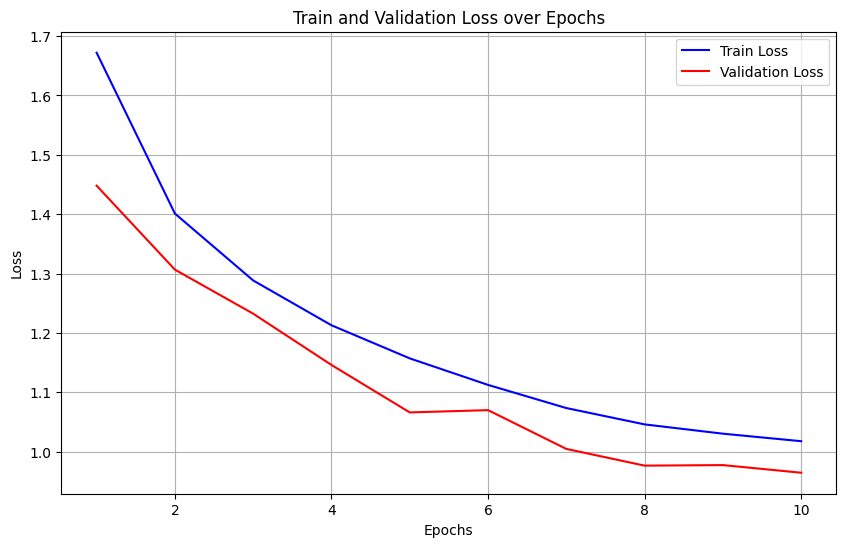

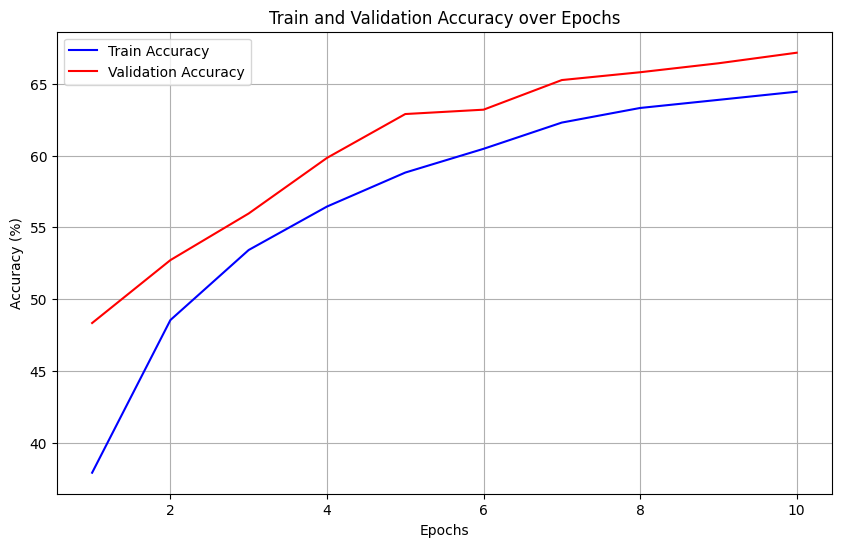

In [11]:
# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='red')
plt.title('Train and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='red')
plt.title('Train and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

# Part 4:

In [62]:
# 3-layer CNN with Batch Normalization for CIFAR-10 classification
class CNN_BatchNorm(nn.Module):
    def __init__(self):
        super(CNN_BatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64) 

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128) 

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

    # Forward pass with ReLU and Batch Normalization
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [13]:
model = CNN_BatchNorm()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss and accuracy values for each epoch
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []  

for epoch in range(10):
    # Training phase
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        optimizer.zero_grad()   # Reset gradients
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()   # Update weights
        total_train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Validation phase
    model.eval()
    total_val_loss = 0.0
    all_pred_labels, all_true_labels = [], []

    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            total_val_loss += criterion(outputs, labels).item()

            # Get predicted and true labels for evaluation
            _, predicted = torch.max(outputs.data, 1)
            all_pred_labels.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    # Compute average training, validation loss, and training accuracy
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_accuracy = 100 * correct_train / total_train
    val_accuracy = 100 * accuracy_score(all_true_labels, all_pred_labels)  

    # Append to lists
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/10], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

# Test phase
model.eval()
all_test_preds, all_test_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:  
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# Compute evaluation metrics on test data
accuracy = 100 * accuracy_score(all_test_labels, all_test_preds)
precision = precision_score(all_test_labels, all_test_preds, average='weighted')
recall = recall_score(all_test_labels, all_test_preds, average='weighted')
f1 = f1_score(all_test_labels, all_test_preds, average='weighted')

print(f'\nFinal Test Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Epoch [1/10], Train Loss: 1.1901, Validation Loss: 0.9877, Train Accuracy: 57.41%
Epoch [2/10], Train Loss: 0.8271, Validation Loss: 0.8009, Train Accuracy: 70.66%
Epoch [3/10], Train Loss: 0.6879, Validation Loss: 0.7937, Train Accuracy: 75.86%
Epoch [4/10], Train Loss: 0.5898, Validation Loss: 0.7545, Train Accuracy: 79.04%
Epoch [5/10], Train Loss: 0.4979, Validation Loss: 0.6455, Train Accuracy: 82.38%
Epoch [6/10], Train Loss: 0.4296, Validation Loss: 0.7509, Train Accuracy: 84.88%
Epoch [7/10], Train Loss: 0.3569, Validation Loss: 0.7732, Train Accuracy: 87.34%
Epoch [8/10], Train Loss: 0.2960, Validation Loss: 0.7159, Train Accuracy: 89.34%
Epoch [9/10], Train Loss: 0.2446, Validation Loss: 0.8001, Train Accuracy: 91.38%
Epoch [10/10], Train Loss: 0.2043, Validation Loss: 0.7374, Train Accuracy: 92.83%

Final Test Accuracy: 77.71%
Precision: 0.7844
Recall: 0.7771
F1-Score: 0.7792


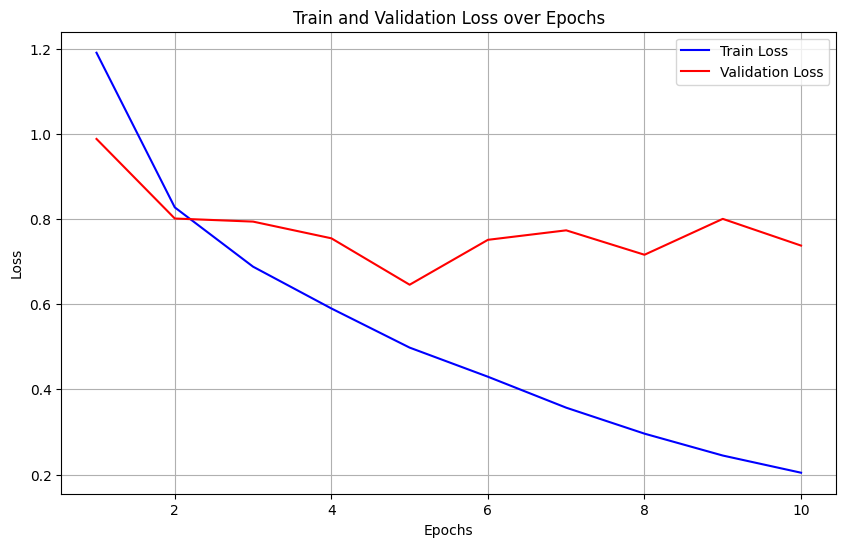

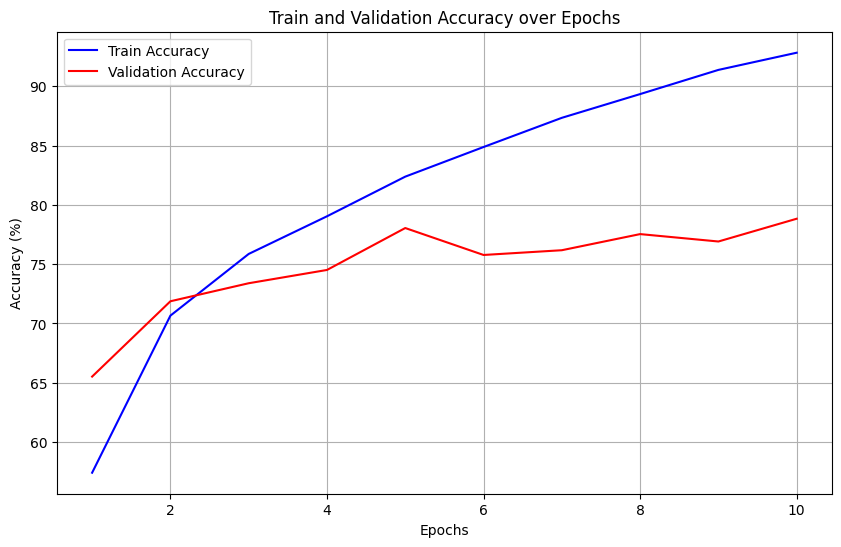

In [14]:
# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='red')
plt.title('Train and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='red')
plt.title('Train and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

# Part 5:

Before Fine-Tune ResNet18

In [ ]:
# Load pre-trained ResNet18
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

# Unfreeze FC layer
for param in model.fc.parameters():
    param.requires_grad = True

print('Ready Model')

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Lists to store loss and accuracy values for each epoch
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(10):
    # Training phase
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Validation phase
    model.eval()
    total_val_loss = 0.0
    all_pred_labels, all_true_labels = [], []

    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            # Get predicted and true labels for evaluation
            _, predicted = torch.max(outputs.data, 1)
            all_pred_labels.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    # Compute average training, validation loss, and training accuracy
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_accuracy = 100 * correct_train / total_train
    val_acc = 100 * accuracy_score(all_true_labels, all_pred_labels)

    # Append to lists
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_acc)

    print(f'Epoch [{epoch + 1}/10], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

# Test phase
model.eval()
all_test_preds, all_test_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# Compute evaluation metrics on test data
accuracy = 100 * accuracy_score(all_test_labels, all_test_preds)
precision = precision_score(all_test_labels, all_test_preds, average='weighted')
recall = recall_score(all_test_labels, all_test_preds, average='weighted')
f1 = f1_score(all_test_labels, all_test_preds, average='weighted')

print(f'\nFinal Test Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

In [ ]:
# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='red')
plt.title('Train and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='red')
plt.title('Train and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

After Fine-Tune ResNet18

In [ ]:
# Load pre-trained ResNet18
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze early layers 
for name, param in model.named_parameters():
    if name.startswith('conv1') or name.startswith('bn1') or name.startswith('layer1'):
        param.requires_grad = False
    else:
        param.requires_grad = True

# Replace FC layer for 10 class CIFAR-10
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

print('Fine-tuning Ready Model')

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# Lists to store loss and accuracy values for each epoch
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(10):
    # Training phase
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Validation phase
    model.eval()
    total_val_loss = 0.0
    all_pred_labels, all_true_labels = [], []

    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            # Get predicted and true labels for evaluation
            _, predicted = torch.max(outputs.data, 1)
            all_pred_labels.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    # Compute average training, validation loss, and training accuracy
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_accuracy = 100 * correct_train / total_train
    val_acc = 100 * accuracy_score(all_true_labels, all_pred_labels)

    # Append to lists
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_acc)

    print(f'Epoch [{epoch + 1}/10], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

# Test phase
model.eval()
all_test_preds, all_test_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# Compute evaluation metrics on test data
accuracy = 100 * accuracy_score(all_test_labels, all_test_preds)
precision = precision_score(all_test_labels, all_test_preds, average='weighted')
recall = recall_score(all_test_labels, all_test_preds, average='weighted')
f1 = f1_score(all_test_labels, all_test_preds, average='weighted')

print(f'\nFinal Test Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

In [ ]:
# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='red')
plt.title('Train and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='red')
plt.title('Train and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

# Part 6:

In [ ]:
aug_train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

basic_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

aug_full_train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=False, transform=aug_train_transform)

aug_test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=False, transform=basic_transform)

train_size = int(0.875 * len(aug_full_train_dataset))
val_size = len(aug_full_train_dataset) - train_size

aug_train_dataset, aug_val_dataset = random_split(
    aug_full_train_dataset, [train_size, val_size])

aug_val_dataset.dataset.transform = basic_transform

aug_train_loader = torch.utils.data.DataLoader(aug_train_dataset, batch_size=64, shuffle=True)
aug_val_loader = torch.utils.data.DataLoader(aug_val_dataset, batch_size=64, shuffle=False)
aug_test_loader = torch.utils.data.DataLoader(aug_test_dataset, batch_size=64, shuffle=False)

print("Augmented dataset loaded and ready.")

Augmented dataset loaded and ready.


In [8]:
# 3-layer CNN for CIFAR-10 classification
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Applies 2x2 max pooling to reduce spatial dimensions by half
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 4 * 4, 256)   
        self.fc2 = nn.Linear(256, 10)  

    # Forward pass with ReLU
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss and accuracy values for each epoch
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []  

for epoch in range(10):
    # Training phase
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in aug_train_loader:
        optimizer.zero_grad()   # Reset gradients
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()   # Update weights
        total_train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Validation phase
    model.eval()
    total_val_loss = 0.0
    all_pred_labels, all_true_labels = [], []

    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in aug_val_loader:
            outputs = model(images)
            total_val_loss += criterion(outputs, labels).item()

            # Get predicted and true labels for evaluation
            _, predicted = torch.max(outputs.data, 1)
            all_pred_labels.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    # Compute average training, validation loss, and training accuracy
    avg_train_loss = total_train_loss / len(aug_train_loader)
    avg_val_loss = total_val_loss / len(aug_val_loader)
    train_accuracy = 100 * correct_train / total_train
    val_accuracy = 100 * accuracy_score(all_true_labels, all_pred_labels)  

    # Append to lists
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/10], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

# Test phase
model.eval()
all_test_preds, all_test_labels = [], []

with torch.no_grad():
    for images, labels in aug_test_loader:  
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# Compute evaluation metrics on test data
accuracy = 100 * accuracy_score(all_test_labels, all_test_preds)
precision = precision_score(all_test_labels, all_test_preds, average='weighted')
recall = recall_score(all_test_labels, all_test_preds, average='weighted')
f1 = f1_score(all_test_labels, all_test_preds, average='weighted')

print(f'\nFinal Test Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Epoch [1/10], Train Loss: 1.3944, Validation Loss: 1.0867, Train Accuracy: 49.43%
Epoch [2/10], Train Loss: 0.9643, Validation Loss: 0.8920, Train Accuracy: 65.84%
Epoch [3/10], Train Loss: 0.7726, Validation Loss: 0.8249, Train Accuracy: 72.89%
Epoch [4/10], Train Loss: 0.6425, Validation Loss: 0.7589, Train Accuracy: 77.55%
Epoch [5/10], Train Loss: 0.5336, Validation Loss: 0.7437, Train Accuracy: 81.41%
Epoch [6/10], Train Loss: 0.4317, Validation Loss: 0.7577, Train Accuracy: 84.77%
Epoch [7/10], Train Loss: 0.3392, Validation Loss: 0.8003, Train Accuracy: 88.21%
Epoch [8/10], Train Loss: 0.2615, Validation Loss: 0.8654, Train Accuracy: 90.86%
Epoch [9/10], Train Loss: 0.2025, Validation Loss: 0.9628, Train Accuracy: 92.89%
Epoch [10/10], Train Loss: 0.1531, Validation Loss: 1.0455, Train Accuracy: 94.66%

Final Test Accuracy: 75.38%
Precision: 0.7560
Recall: 0.7538
F1-Score: 0.7537


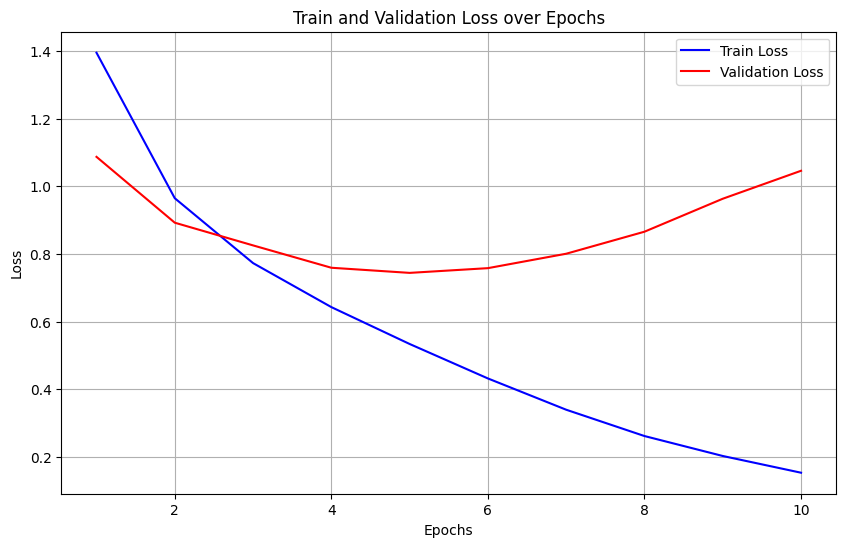

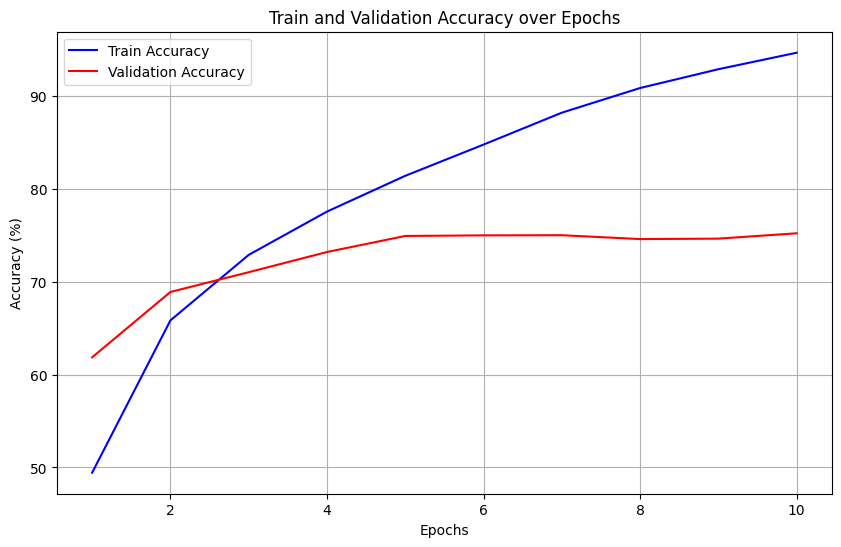

In [10]:
# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='red')
plt.title('Train and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='red')
plt.title('Train and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

# Part 7:

Fixed Learning Rate:

In [ ]:
# 3-layer CNN for CIFAR-10 classification
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Applies 2x2 max pooling to reduce spatial dimensions by half
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 4 * 4, 256)   
        self.fc2 = nn.Linear(256, 10)  

    # Forward pass with ReLU
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss and accuracy values for each epoch
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []  

for epoch in range(10):
    # Training phase
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        optimizer.zero_grad()   # Reset gradients
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()   # Update weights
        total_train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Validation phase
    model.eval()
    total_val_loss = 0.0
    all_pred_labels, all_true_labels = [], []

    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            total_val_loss += criterion(outputs, labels).item()

            # Get predicted and true labels for evaluation
            _, predicted = torch.max(outputs.data, 1)
            all_pred_labels.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    # Compute average training, validation loss, and training accuracy
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_accuracy = 100 * correct_train / total_train
    val_accuracy = 100 * accuracy_score(all_true_labels, all_pred_labels)  

    # Append to lists
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/10], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

# Test phase
model.eval()
all_test_preds, all_test_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:  
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# Compute evaluation metrics on test data
accuracy = 100 * accuracy_score(all_test_labels, all_test_preds)
precision = precision_score(all_test_labels, all_test_preds, average='weighted')
recall = recall_score(all_test_labels, all_test_preds, average='weighted')
f1 = f1_score(all_test_labels, all_test_preds, average='weighted')

print(f'\nFinal Test Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

In [ ]:
# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='red')
plt.title('Train and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='red')
plt.title('Train and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

Step Learning Rate:

In [11]:
# 3-layer CNN for CIFAR-10 classification
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Applies 2x2 max pooling to reduce spatial dimensions by half
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 4 * 4, 256)   
        self.fc2 = nn.Linear(256, 10)  

    # Forward pass with ReLU
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
model_stepLR = CNN()
criterion = nn.CrossEntropyLoss()
optimizer_stepLR = optim.Adam(model_stepLR.parameters(), lr=0.001)

# Define StepLR scheduler: reduce LR by gamma every step_size epochs
scheduler_stepLR = optim.lr_scheduler.StepLR(optimizer_stepLR, step_size=5, gamma=0.5)

# Lists to store loss and accuracy values for each epoch
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(10):
    # Training phase
    model_stepLR.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        optimizer_stepLR.zero_grad()   # Reset gradients
        outputs = model_stepLR(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_stepLR.step()   # Update weights
        total_train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Step the scheduler to update learning rate
    scheduler_stepLR.step()

    # Validation phase
    model_stepLR.eval()
    total_val_loss = 0.0
    all_pred_labels, all_true_labels = [], []

    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model_stepLR(images)
            total_val_loss += criterion(outputs, labels).item()

            # Get predicted and true labels for evaluation
            _, predicted = torch.max(outputs.data, 1)
            all_pred_labels.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    # Compute average training, validation loss, and training accuracy
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_accuracy = 100 * correct_train / total_train
    val_accuracy = 100 * accuracy_score(all_true_labels, all_pred_labels)  

    # Append to lists
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/10], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

# Test phase
model_stepLR.eval()
all_test_preds, all_test_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:  
        outputs = model_stepLR(images)
        _, predicted = torch.max(outputs.data, 1)
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# Compute evaluation metrics on test data
accuracy = 100 * accuracy_score(all_test_labels, all_test_preds)
precision = precision_score(all_test_labels, all_test_preds, average='weighted')
recall = recall_score(all_test_labels, all_test_preds, average='weighted')
f1 = f1_score(all_test_labels, all_test_preds, average='weighted')

print(f'\nFinal Test Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Epoch [1/10], Train Loss: 1.4098, Validation Loss: 1.0786, Train Accuracy: 48.82%
Epoch [2/10], Train Loss: 0.9745, Validation Loss: 0.8940, Train Accuracy: 65.53%
Epoch [3/10], Train Loss: 0.7839, Validation Loss: 0.7831, Train Accuracy: 72.62%
Epoch [4/10], Train Loss: 0.6474, Validation Loss: 0.7601, Train Accuracy: 77.24%
Epoch [5/10], Train Loss: 0.5285, Validation Loss: 0.7661, Train Accuracy: 81.60%
Epoch [6/10], Train Loss: 0.3508, Validation Loss: 0.7309, Train Accuracy: 87.79%
Epoch [7/10], Train Loss: 0.2709, Validation Loss: 0.7783, Train Accuracy: 90.63%
Epoch [8/10], Train Loss: 0.2053, Validation Loss: 0.8551, Train Accuracy: 93.12%
Epoch [9/10], Train Loss: 0.1538, Validation Loss: 0.9175, Train Accuracy: 94.94%
Epoch [10/10], Train Loss: 0.1096, Validation Loss: 1.0251, Train Accuracy: 96.47%

Final Test Accuracy: 75.39%
Precision: 0.7561
Recall: 0.7539
F1-Score: 0.7543


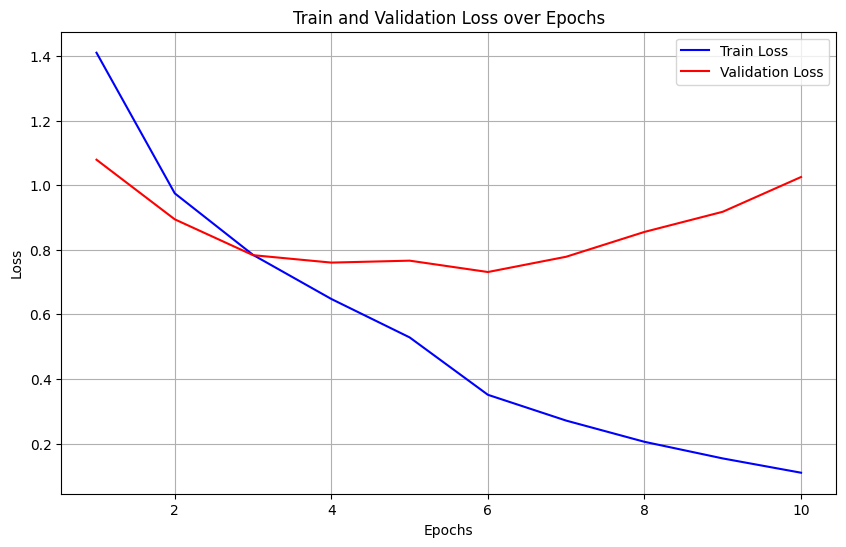

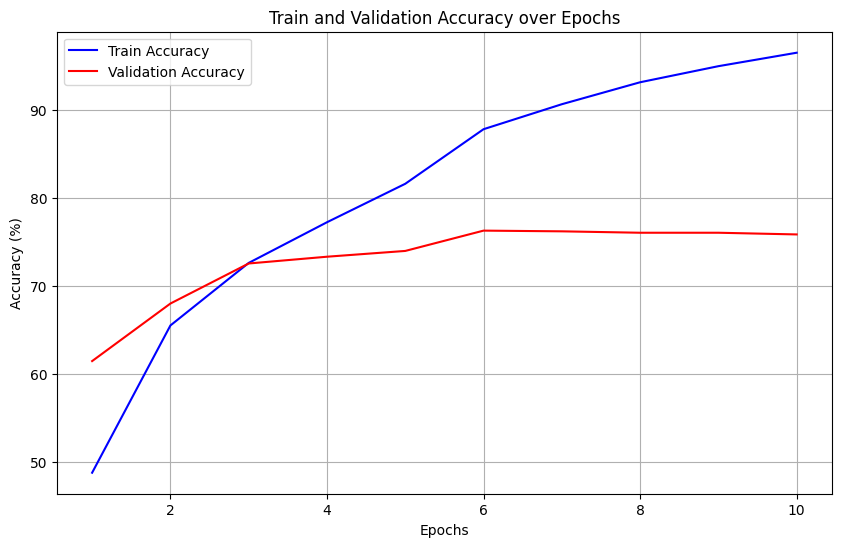

In [13]:
# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='red')
plt.title('Train and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='red')
plt.title('Train and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

Cosine Annealing:

In [14]:
# 3-layer CNN for CIFAR-10 classification
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Applies 2x2 max pooling to reduce spatial dimensions by half
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 4 * 4, 256)   
        self.fc2 = nn.Linear(256, 10)  

    # Forward pass with ReLU
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [8]:
model_cosine = CNN()
criterion = nn.CrossEntropyLoss()
optimizer_cosine = optim.Adam(model_cosine.parameters(), lr=0.001)

# Define Cosine Annealing scheduler
scheduler_cosine = optim.lr_scheduler.CosineAnnealingLR(optimizer_cosine, T_max=10, eta_min=0.0001)

# Lists to store loss and accuracy values for each epoch
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(10):
    # Training phase
    model_cosine.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        optimizer_cosine.zero_grad()   # Reset gradients
        outputs = model_cosine(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_cosine.step()   # Update weights
        total_train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Step the scheduler to update learning rate
    scheduler_cosine.step()

    # Validation phase
    model_cosine.eval()
    total_val_loss = 0.0
    all_pred_labels, all_true_labels = [], []

    # Validate without gradient tracking
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model_cosine(images)
            total_val_loss += criterion(outputs, labels).item()

            # Get predicted and true labels for evaluation
            _, predicted = torch.max(outputs.data, 1)
            all_pred_labels.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    # Compute average training, validation loss, and training accuracy
    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)
    train_accuracy = 100 * correct_train / total_train
    val_accuracy = 100 * accuracy_score(all_true_labels, all_pred_labels)  

    # Append to lists
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch + 1}/10], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

# Test phase
model_cosine.eval()
all_test_preds, all_test_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:  
        outputs = model_cosine(images)
        _, predicted = torch.max(outputs.data, 1)
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# Compute evaluation metrics on test data
accuracy = 100 * accuracy_score(all_test_labels, all_test_preds)
precision = precision_score(all_test_labels, all_test_preds, average='weighted')
recall = recall_score(all_test_labels, all_test_preds, average='weighted')
f1 = f1_score(all_test_labels, all_test_preds, average='weighted')

print(f'\nFinal Test Accuracy: {accuracy:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Epoch [1/10], Train Loss: 1.3828, Validation Loss: 1.0804, Train Accuracy: 49.88%
Epoch [2/10], Train Loss: 0.9493, Validation Loss: 0.9057, Train Accuracy: 66.43%
Epoch [3/10], Train Loss: 0.7423, Validation Loss: 0.8021, Train Accuracy: 73.95%
Epoch [4/10], Train Loss: 0.5985, Validation Loss: 0.7582, Train Accuracy: 78.98%
Epoch [5/10], Train Loss: 0.4754, Validation Loss: 0.7768, Train Accuracy: 83.38%
Epoch [6/10], Train Loss: 0.3533, Validation Loss: 0.7809, Train Accuracy: 87.66%
Epoch [7/10], Train Loss: 0.2524, Validation Loss: 0.8348, Train Accuracy: 91.59%
Epoch [8/10], Train Loss: 0.1722, Validation Loss: 0.8868, Train Accuracy: 94.65%
Epoch [9/10], Train Loss: 0.1155, Validation Loss: 0.9451, Train Accuracy: 96.90%
Epoch [10/10], Train Loss: 0.0831, Validation Loss: 0.9868, Train Accuracy: 98.08%

Final Test Accuracy: 77.01%
Precision: 0.7687
Recall: 0.7701
F1-Score: 0.7688


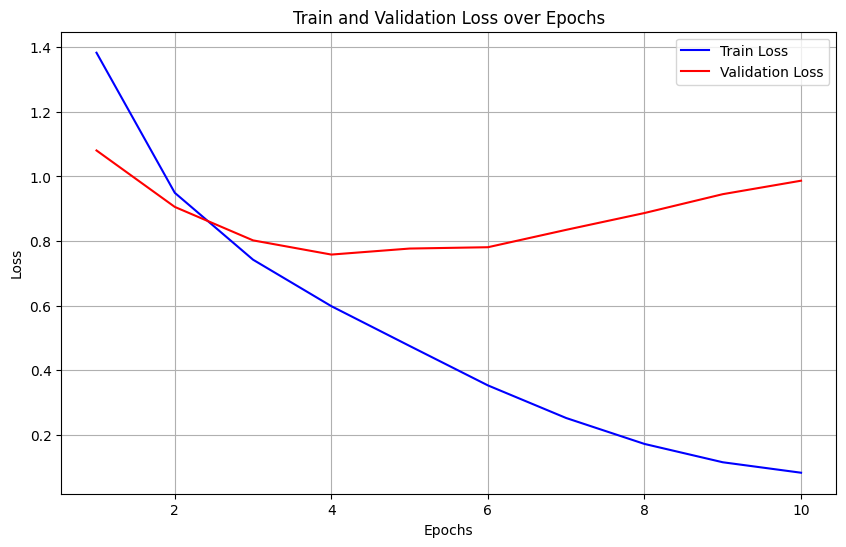

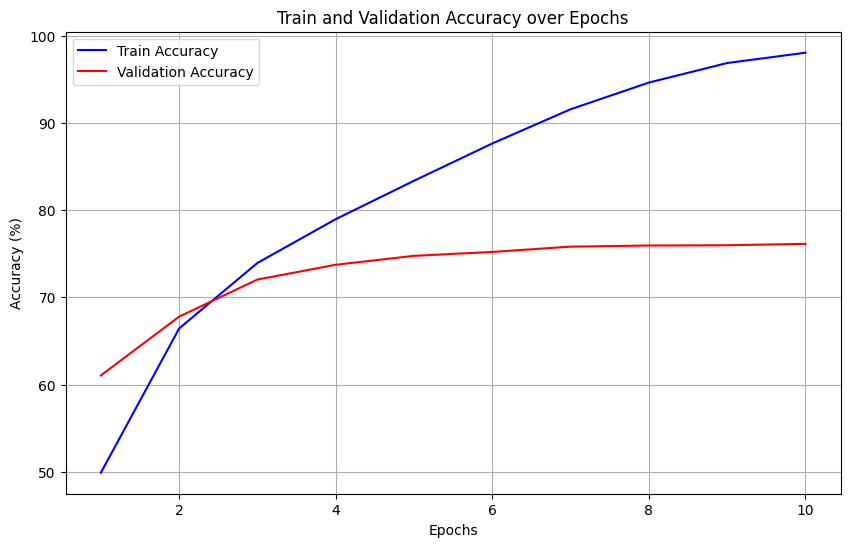

In [9]:
# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='red')
plt.title('Train and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='red')
plt.title('Train and Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

# Part 8:

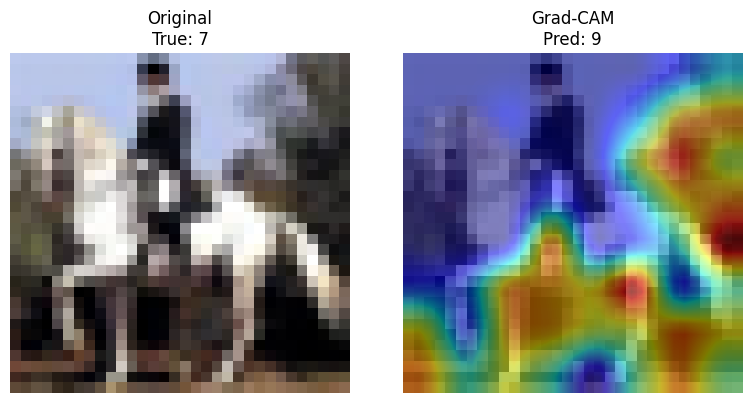

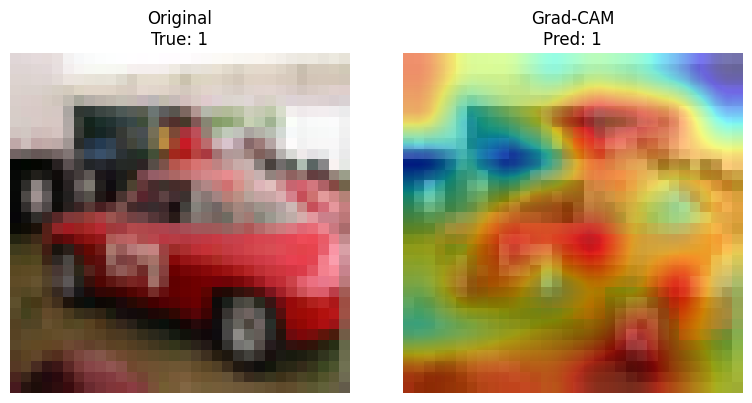

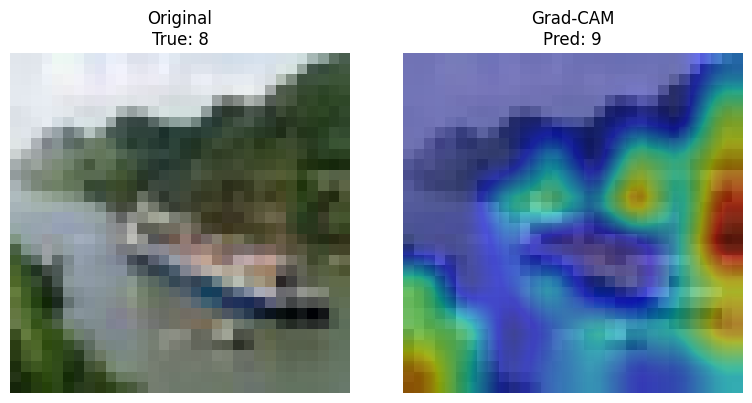

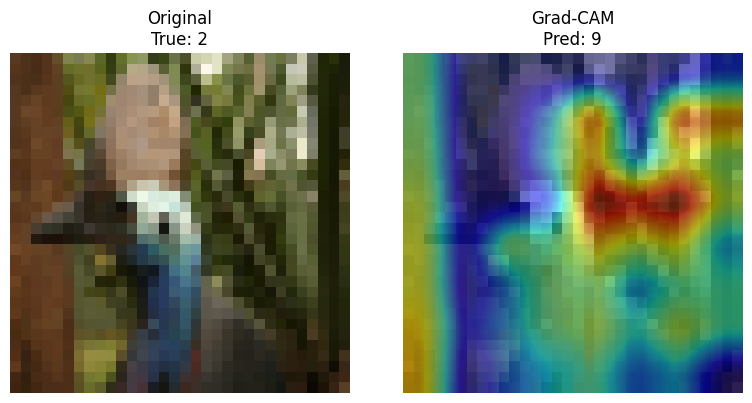

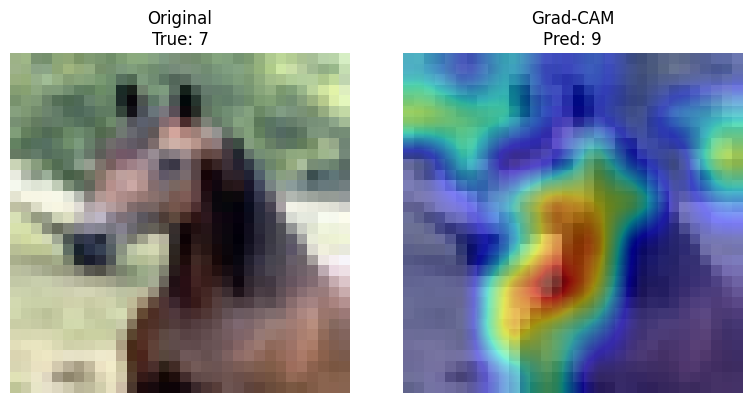

In [ ]:
model = CNN_BatchNorm()
model.eval()
cam_extractor = GradCAM(model, target_layer=model.conv3)

# Reverse normalization for display
def denormalize(tensor):
    mean = torch.tensor([0.5, 0.5, 0.5]).view(3,1,1)
    std  = torch.tensor([0.5, 0.5, 0.5]).view(3,1,1)
    return tensor * std + mean

# Visualize original image and Grad-CAM overlay
def show_gradcam_pair(image_tensor, cam_map, true_label, pred_label):
    img_denorm = denormalize(image_tensor).clamp(0,1)
    img_np = np.array(to_pil_image(img_denorm))
    
    # Upsample CAM to match input size
    if cam_map.ndim == 2:
        cam = cam_map.unsqueeze(0).unsqueeze(0)
    else:
        cam = cam_map.unsqueeze(0)
    cam_up = F.interpolate(cam, size=(32, 32), mode='bilinear', align_corners=False)[0,0]
    heat   = (cam_up - cam_up.min()) / (cam_up.max() - cam_up.min() + 1e-8)
    fig, axs = plt.subplots(1, 2, figsize=(8,4))
    
    # Plot: original vs. Grad-CAM
    axs[0].imshow(img_np)
    axs[0].set_title(f"Original\nTrue: {true_label}")
    axs[0].axis('off')
    
    axs[1].imshow(img_np)
    axs[1].imshow(heat.cpu().numpy(), cmap='jet', alpha=0.5, interpolation='bilinear')
    axs[1].set_title(f"Grad-CAM\nPred: {pred_label}")
    axs[1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize 5 random test samples using Grad-CAM
indices = random.sample(range(len(test_dataset)), 5)
for idx in indices:
    img, label = test_dataset[idx]
    inp = img.unsqueeze(0)
    out = model(inp)
    pred = out.argmax(dim=1).item()
    cams = cam_extractor(pred, out)
    cam_map = cams[0]
    show_gradcam_pair(img, cam_map, true_label=label, pred_label=pred)